In [2]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from utils import data_path,results_path,grid_search,estimator_result,cross_validate,evaluate_param,rfecv
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV,VarianceThreshold

# Algorithm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
train_X = load_npz(data_path + 'version_1/'+ 'train_freq.npz')
test_X = load_npz(data_path + 'version_1/'+ 'test_freq.npz')

train_y = pd.read_csv(data_path + 'train_Y.csv')['CMV_status']
test_y = pd.read_csv(data_path + 'test_Y.csv')['CMV_status']

**Select top 70 features(in terms of p-values)**

In [4]:
with open(data_path + 'sorted_TCRs_ind.pkl', 'rb') as f:
    TCRs_ind = pickle.load(f)

p = 70
ind = TCRs_ind[:p]
train_X_sub = train_X[:,ind].toarray()
test_X_sub = test_X[:,ind].toarray()

## Define classifiers

In [5]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=31, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=5,
                min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
                oob_score=True, random_state=0, verbose=0, warm_start=False)
lr = LogisticRegression(class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
                            penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
                            verbose=0, warm_start=False)
   
lr_l1 = LogisticRegression(class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
                            penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
                            verbose=0, warm_start=False)

## RFE for feature selection and Gridsearch for parameter tunning

### LR with L2

Optimal number of features : 70
Max cv score :  0.954622136210806

Testing set:
AUROC: 0.9258312020460359 Accuracy:  0.875
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


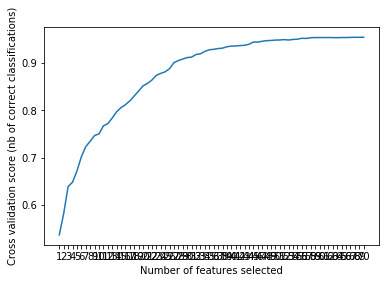

In [6]:
# p = 70
kept_ind = rfecv(train_X[:,TCRs_ind[:70]],train_y,test_X[:,TCRs_ind[:70]],test_y,lr)

In [45]:
param_grid = {
#     'C':[0.01,0.1,1,10,100]
      'C':[1,2,3,4,5],
#       'fit_intercept':[True,False]
      'intercept_scaling':[0.1,0.5,1,2,3,4,5],
#       'class_weight':[None,'balanced']
}
grid_search(lr,train_X_sub[:,kept_ind],train_y,test_X_sub[:,kept_ind],test_y,param_grid)

Parameter_grid: {'C': [1, 2, 3, 4, 5], 'intercept_scaling': [0.1, 0.5, 1, 2, 3, 4, 5]}
Best parameters set found on development set for AUC

{'C': 1, 'intercept_scaling': 0.5}

Best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.5, max_iter=100, multi_class='ovr',
          n_jobs=-1, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Grid scores on training set:

AUROC: 0.938 (+/-0.035), Accuracy: 0.869 (+/-0.060) for {'C': 1, 'intercept_scaling': 0.1}
AUROC: 0.955 (+/-0.036), Accuracy: 0.908 (+/-0.074) for {'C': 1, 'intercept_scaling': 0.5}
AUROC: 0.955 (+/-0.037), Accuracy: 0.903 (+/-0.070) for {'C': 1, 'intercept_scaling': 1}
AUROC: 0.955 (+/-0.036), Accuracy: 0.905 (+/-0.070) for {'C': 1, 'intercept_scaling': 2}
AUROC: 0.955 (+/-0.036), Accuracy: 0.905 (+/-0.070) for {'C': 1, 'intercept_scaling': 3}
AUROC: 0.955 (+/-0.036), Accuracy: 0.905 (+/-0.070) for {'C': 1,

In [8]:
# with open(data_path + 'feature_selection/'+'bin/'+'best_lr_70', 'wb') as f:
#     pickle.dump(kept_ind, f, pickle.HIGHEST_PROTOCOL)

### LR with L1

Optimal number of features : 70
Max cv score :  0.9481587692548287

Testing set:
AUROC: 0.9161693662972434 Accuracy:  0.875
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

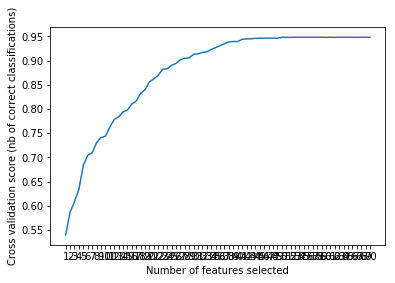

In [11]:
# p = 69
rfecv(train_X[:,ind],train_y,test_X[:,ind],test_y,lr_l1)

Optimal number of features : 69
Max cv score :  0.9481587692548287

Testing set:
AUROC: 0.9161693662972434 Accuracy:  0.875
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


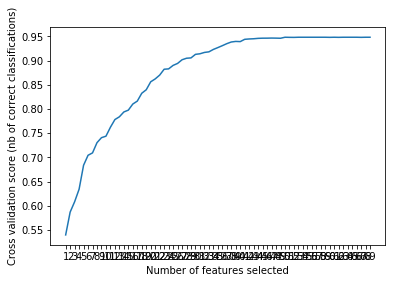

In [16]:
# p = 69
kept_ind2 = rfecv(train_X[:,TCRs_ind[:69]],train_y,test_X[:,TCRs_ind[:69]],test_y,lr_l1)

In [48]:
param_grid = {
    'C':[0.01,0.1,1,2,3,10,100],
#           'fit_intercept':[True,False]
      'intercept_scaling':[0.1,0.5,1,2,3,4,5],
#       'class_weight':[None,'balanced']
}
grid_search(lr_l1,train_X_sub[:,kept_ind2],train_y,test_X_sub[:,kept_ind2],test_y,param_grid)

Parameter_grid: {'C': [0.01, 0.1, 1, 2, 3, 10, 100], 'intercept_scaling': [0.1, 0.5, 1, 2, 3, 4, 5], 'class_weight': [None, 'balanced']}
Best parameters set found on development set for AUC

{'C': 1, 'class_weight': None, 'intercept_scaling': 0.5}

Best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.5, max_iter=100, multi_class='ovr',
          n_jobs=-1, penalty='l1', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Grid scores on training set:

AUROC: 0.500 (+/-0.000), Accuracy: 0.549 (+/-0.007) for {'C': 0.01, 'class_weight': None, 'intercept_scaling': 0.1}
AUROC: 0.500 (+/-0.000), Accuracy: 0.549 (+/-0.007) for {'C': 0.01, 'class_weight': None, 'intercept_scaling': 0.5}
AUROC: 0.500 (+/-0.000), Accuracy: 0.549 (+/-0.007) for {'C': 0.01, 'class_weight': None, 'intercept_scaling': 1}
AUROC: 0.500 (+/-0.000), Accuracy: 0.549 (+/-0.007) for {'C': 0.01, 'class_weight': None, 'inte

### RF

Optimal number of features : 68
Max cv score :  0.9492851278442412

Testing set:
AUROC: 0.9292412617220801 Accuracy:  0.8833333333333333
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 54 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

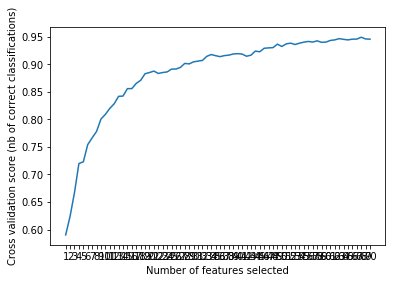

In [18]:
# p = 70
rfecv(train_X_sub,train_y,test_X_sub,test_y,rf)

**The 53,55 features are dropped**

Optimal number of features : 69
Max cv score :  0.9498133161310502

Testing set:
AUROC: 0.9215686274509803 Accuracy:  0.9
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68])

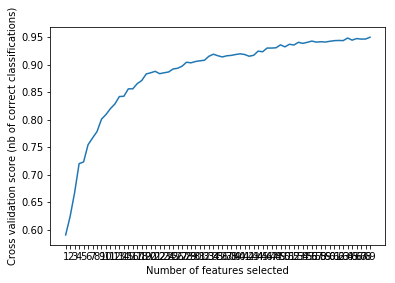

In [20]:
# p = 69
kept_ind3 = rfecv(train_X[:,TCRs_ind[:69]],train_y,test_X[:,TCRs_ind[:69]],test_y,rf)

(Seems that the 67th makes an affect)

**The 53th feature is dropped**

In [ ]:
# with open(data_path + 'feature_selection/'+'freq/'+'best_rf_61', 'wb') as f:
#     pickle.dump(kept_ind3, f, pickle.HIGHEST_PROTOCOL)

#### Parameter tunning